## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
1. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
1. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. 

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [163]:
df = pd.read_csv('Kobe.csv')

In [165]:
target = 'shot_made_flag'

In [166]:
for i in df.columns:
    if df[i].isna().sum() == 0: continue
    print(f' column {i}, missed values= {df[i].isna().sum()}')   

 column shot_made_flag, missed values= 5000


Пропущенных значений в выборке нет, кроме 5000 пропущенных значений целевой переменной (которую нужно предсказать по условию задачи)

In [167]:
# Соберем все категории
categories = list(df.columns[df.dtypes == object])

#### Числовые признаки

In [168]:
# Соберем все остальные столбцы, кроме категорийных
numerical = [i for i in list(df.columns) if i not in categories]

In [169]:
# вот еще категорийные признаки
for i in numerical:
    if df[i].nunique() > 50: continue
    print(i, df[i].unique(), df[i].nunique())
    print('-'*55)

minutes_remaining [10  7  6  9  8  3  1 11  2  0  5  4] 12
-------------------------------------------------------
period [1 2 3 4 5 6 7] 7
-------------------------------------------------------
playoffs [0 1] 2
-------------------------------------------------------
shot_made_flag [nan  0.  1.] 2
-------------------------------------------------------
team_id [1610612747] 1
-------------------------------------------------------


In [170]:
# Признак team_id [1610612747] имеет всего одно значение. Не имеет никакого смысла.
df.drop(columns='team_id',inplace=True)

In [171]:
# Добавим в categories признаки : ['period','playoffs']
categories += ['period','playoffs']

In [172]:
# Соберем все остальные столбцы, кроме категорийных
numerical = [i for i in list(df.columns) if i not in categories + ['team_id']]

In [173]:
# Проверим координаты:
df.loc[df.loc_y==0,['lat','lon','loc_y', 'loc_x']].value_counts()

lat      lon        loc_y  loc_x
34.0443  -118.2698  0       0       5182
         -118.2708  0      -1          9
         -118.2858  0      -16         8
         -118.2678  0       2          6
         -118.2848  0      -15         6
                                    ... 
         -118.2308  0       39         1
         -118.2318  0       38         1
         -118.2338  0       36         1
         -118.2368  0       33         1
         -118.5098  0      -240        1
Length: 239, dtype: int64

Координаты 34.0443  -118.2698 - 34°02'39.5"N 118°16'11.3"W - это Staples Center центральная арена, где играет Los Angeles Lakers команда за которую играл  Kobe Bryant.  

Вместо 4 столбцов создам одну категориальную - "Дома"

In [174]:
df['Home'] = ((df.loc_y==0)&(df.loc_x==0)).astype('int')
df.drop(columns=['lat','lon','loc_y', 'loc_x'],inplace=True)
categories += ['Home']

In [175]:
# Уберем столбцы ['lat','lon','loc_y', 'loc_x']
numerical = [i for i in numerical if i not in ['lat','lon','loc_y', 'loc_x']]

In [176]:
# Проверим столбцы с именем id:
len(df), len(df.shot_id), len(df.game_id), len(df.game_event_id)

(30697, 30697, 30697, 30697)

In [177]:
# создадим один параметр "оставшееся время" в который объединю оставшиеся секунды + оставшиеся минуты
df['time_remaining'] = df['seconds_remaining']+ df['minutes_remaining']*60

In [178]:
# Уберем столбцы ['game_event_id','game_id','shot_id', 'seconds_remaining', 'minutes_remaining']
df.drop(columns=['game_event_id','game_id','shot_id', 'seconds_remaining', 'minutes_remaining'],inplace=True)

In [179]:
# Уберем столбцы ['lat','lon','loc_y', 'loc_x']
numerical = [i for i in numerical if i not in ['game_event_id','game_id','shot_id', 'seconds_remaining', 'minutes_remaining']]

In [192]:
# Проверим оставшиеся числовые признаки
numerical = [i for i in numerical if i not in ['shot_made_flag']] + ['time_remaining']
numerical

['shot_distance', 'time_remaining']

#### Категорийные признаки

In [181]:
" , ".join(categories)

'action_type , combined_shot_type , season , shot_type , shot_zone_area , shot_zone_basic , shot_zone_range , team_name , game_date , matchup , opponent , period , playoffs'

In [182]:
# Уберем бинарные категории
categories_binary = []
for i in categories:
    if df[i].nunique() == 2 : 
        print(i)
        print('-'*55)
        categories_binary.append(i)
print(categories_binary)
categories = [i for i in categories if i not in categories_binary]

shot_type
-------------------------------------------------------
playoffs
-------------------------------------------------------
['shot_type', 'playoffs']


In [183]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [184]:
# создаем бинарные столбцы
dummy_binary = pd.DataFrame({i:le.fit_transform( df[i] ) for i in categories_binary })
dummy_binary_descr = {i:(le.fit( df[i] ).classes_) for i in categories_binary }
dummy_binary_descr

{'shot_type': array(['2PT Field Goal', '3PT Field Goal'], dtype=object),
 'playoffs': array([0, 1], dtype=int64)}

In [187]:
df[categories].head(2)

,action_type,combined_shot_type,season,shot_zone_area,shot_zone_basic,shot_zone_range,team_name,game_date,matchup,opponent,period
0,Jump Shot,Jump Shot,2000-01,Right Side(R),Mid-Range,16-24 ft.,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,2000-01,Left Side(L),Mid-Range,8-16 ft.,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1


In [201]:
# 'shot_zone_range' по смыслу совпадает с 'shot_distance'. Уберем 'shot_zone_range'
df.drop(columns=['shot_zone_range'],inplace=True)
categories = [i for i in categories if i not in ['shot_zone_range']]

In [198]:
# 'action_type' и 'combined_shot_type' по смыслу совпадают проверим. 
df.action_type.unique(), df.combined_shot_type.unique()

(array(['Jump Shot', 'Driving Dunk Shot', 'Layup Shot',
        'Running Jump Shot', 'Driving Layup Shot', 'Reverse Layup Shot',
        'Reverse Dunk Shot', 'Slam Dunk Shot', 'Turnaround Jump Shot',
        'Tip Shot', 'Running Hook Shot', 'Alley Oop Dunk Shot',
        'Dunk Shot', 'Alley Oop Layup shot', 'Running Dunk Shot',
        'Driving Finger Roll Shot', 'Running Layup Shot',
        'Finger Roll Shot', 'Fadeaway Jump Shot', 'Follow Up Dunk Shot',
        'Hook Shot', 'Turnaround Hook Shot', 'Running Tip Shot',
        'Jump Hook Shot', 'Running Finger Roll Shot', 'Jump Bank Shot',
        'Turnaround Finger Roll Shot', 'Hook Bank Shot',
        'Driving Hook Shot', 'Running Reverse Layup Shot',
        'Driving Finger Roll Layup Shot', 'Fadeaway Bank shot',
        'Pullup Jump shot', 'Finger Roll Layup Shot',
        'Turnaround Fadeaway shot', 'Driving Reverse Layup Shot',
        'Driving Slam Dunk Shot', 'Step Back Jump shot',
        'Reverse Slam Dunk Shot', 'Turnaround

In [200]:
# Уберем 'action_type' Так как больше значений чем 'combined_shot_type' .
df.drop(columns=['action_type'],inplace=True)
categories = [i for i in categories if i not in ['action_type']]

In [202]:
df[categories].head(2)

,combined_shot_type,season,shot_zone_area,shot_zone_basic,team_name,game_date,matchup,opponent,period,Home
0,Jump Shot,2000-01,Right Side(R),Mid-Range,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1,0
1,Jump Shot,2000-01,Left Side(L),Mid-Range,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1,0


In [206]:
# Уберем 'team_name' Так как игрок всегда выступал только за lakers.
df.team_name.unique()

array(['Los Angeles Lakers'], dtype=object)

In [216]:
df.drop(columns=['team_name'],inplace=True)
categories = [i for i in categories if i not in ['team_name']]

In [217]:
# Уберем 'matchup' Так как столбец 'opponent' дублирует это значение
df.drop(columns=['matchup'],inplace=True)
categories = [i for i in categories if i not in ['matchup']]

In [207]:
# заменим 'game_date' месяцем игры, так как нет смысла под каждую игру создавать категорию
df.game_date.unique()

array(['2000-10-31', '2000-11-01', '2000-11-04', ..., '2000-06-14',
       '2000-06-16', '2000-06-19'], dtype=object)

In [215]:
df['game_month'] = [i[5:7] for i in df.game_date]
categories += ['game_month']
df.drop(columns=['game_date'],inplace=True)
categories = [i for i in categories if i not in ['game_date']]

In [224]:
# Создаем дамми:
dummy = pd.get_dummies(df[categories], columns=categories)

#### Объединим:

In [228]:
X_raw = pd.concat( [df[numerical],dummy_binary, dummy],axis=1)

In [229]:
X_raw.shape, df.shape

((30697, 94), (30697, 13))

#### Разделим на X, X_pred(которую нужно предугадать)

In [231]:
X = pd.DataFrame( X_raw[~np.isnan(df['shot_made_flag'])] )
X_pred = pd.DataFrame( X_raw[np.isnan(df['shot_made_flag'])] )

In [237]:
# Создадим целевую переменную
y = df[~np.isnan(df['shot_made_flag'])].shot_made_flag.astype('int')

### ДЗ №3.
Обучить линейную модель, Lasso, Ridge. построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются.

In [258]:
from sklearn.linear_model import LogisticRegression,Lasso,RidgeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler

import shap

#### ExtraTree

In [241]:
light_tree = ExtraTreesClassifier().fit(X,y)

<BarContainer object of 10 artists>

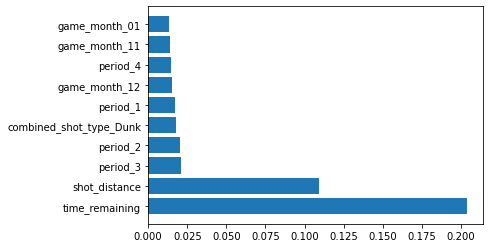

In [253]:
features = pd.Series(data=light_tree.feature_importances_, index=X.columns)
features.sort_values(ascending=False,inplace=True)
plt.barh(y=list(range(10)),width=features.head(10),tick_label=list(features.head(10).index))

In [334]:
features.head(3)

time_remaining    0.203994
shot_distance     0.109576
period_3          0.021003
dtype: float64

#### LogisticRegression

In [255]:
scaler = StandardScaler()

In [256]:
X_scaled = scaler.fit_transform(X)

In [260]:
logit = LogisticRegression().fit(X_scaled,y)

<BarContainer object of 10 artists>

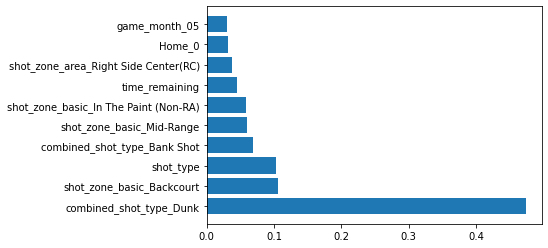

In [265]:
features_logit = pd.Series(data=logit.coef_[0], index=X.columns)
features_logit.sort_values(ascending=False,inplace=True)
plt.barh(y=list(range(10)),width=features_logit.head(10),tick_label=list(features_logit.head(10).index))

In [335]:
features_logit.head(3)

combined_shot_type_Dunk      0.473720
shot_zone_basic_Backcourt    0.105652
shot_type                    0.102193
dtype: float64

#### Lasso,RidgeClassifier

Lasso - для регрессионых моделей. А тут классификации. Не подходит. Нужен классификатор - например SVM, но SVM не построит значимость признаков. sklearn.svm.LinearSVC - по сути это Ridge.

In [327]:
alphas = np.linspace(1,100,100)
result = []

for i in alphas:
    ridge = RidgeClassifier(alpha=i).fit(X_scaled,y)
    result.append(ridge.coef_)

In [328]:
coef = np.vstack(result)
order = coef[0,:].argsort()
coef = coef[:,order]

In [329]:
names = X.columns[order]

In [330]:
# top 5 features
list(zip(coef[0,:],names))[-5:]

[(0.028800346954417536, 'shot_zone_basic_Mid-Range'),
 (0.028973258713088156, 'combined_shot_type_Layup'),
 (0.03173822393972566, 'combined_shot_type_Bank Shot'),
 (0.045972083324357024, 'shot_type'),
 (0.16049181515200842, 'combined_shot_type_Dunk')]

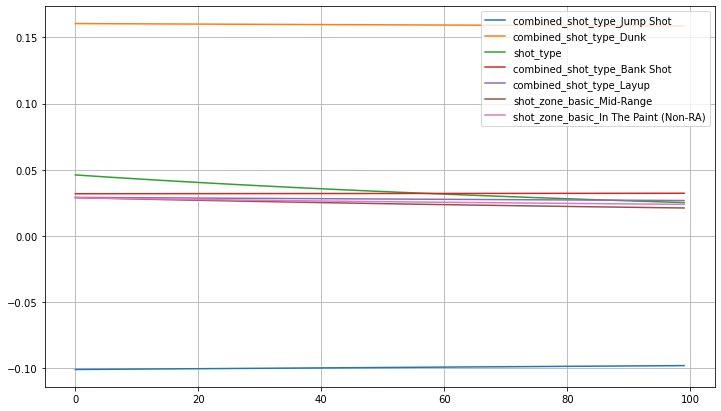

In [332]:
plt.figure(figsize=(12,7))
for i in range(7):
    plt.plot(range(100), coef[:,-i],label=names[-i])

plt.legend(loc='best')    
plt.grid()

### Выводы:
1. Extra Tree Classifier  определил следующие признаки главыми: 
- time_remaining    0.203994
- shot_distance     0.109576
- period_3          0.021003

2. LogisticRegression определил следующие признаки главыми:
- combined_shot_type_Dunk      0.473720
- shot_zone_basic_Backcourt    0.105652
- shot_type                    0.102193

3. RidgeClassifier определил следующие признаки главыми:
- combined_shot_type_Dunk       0.1604
- shot_type                     0.0459
- combined_shot_type_Bank Shot  0.0317 


Частично совпадают признаки у LogisticRegression и RidgeClassifier
1. combined_shot_type_Dunk
1. shot_type

Вес признака shot_type снижается с ростом регуляризации. 

**Дополнительно**
1. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
1. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [240]:
from sklearn.decomposition import PCA
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

In [349]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3,random_state=255)

In [383]:
#Tree
light_tree = ExtraTreesClassifier().fit(X_train,y_train)
y_pred = light_tree.predict(X_test)
y_pred_proba= light_tree.predict_proba(X_test)
ra_score_tree = roc_auc_score(y_test,y_pred)
tpr_tree,fpr_tree,_ = roc_curve(y_test, y_pred_proba[:,0])
ra_score_tree

0.5599470161669721

In [354]:
# Logit
logit = LogisticRegression().fit(X_train,y_train)

y_pred = logit.predict(X_test)
y_pred_proba= logit.predict_proba(X_test)

ra_score_logit = roc_auc_score(y_test,y_pred)
tpr_logit,fpr_logit,_ = roc_curve(y_test, y_pred_proba[:,0])
ra_score_logit

0.5887044697043128

In [356]:
#Ridge alpha=40
ridge = RidgeClassifier(alpha=40).fit(X_train,y_train)

y_pred = ridge.predict(X_test)

ra_score_ridge = roc_auc_score(y_test,y_pred)

ra_score_ridge

0.5886984330015693

In [384]:
### Сравним результаты :
print(f'ExtraTree \t {ra_score_tree :.7f}')
print(f'Logit \t\t {ra_score_logit :.7f}')
print(f'Ridge \t\t {ra_score_ridge :.7f}')


ExtraTree 	 0.5599470
Logit 		 0.5887045
Ridge 		 0.5886984


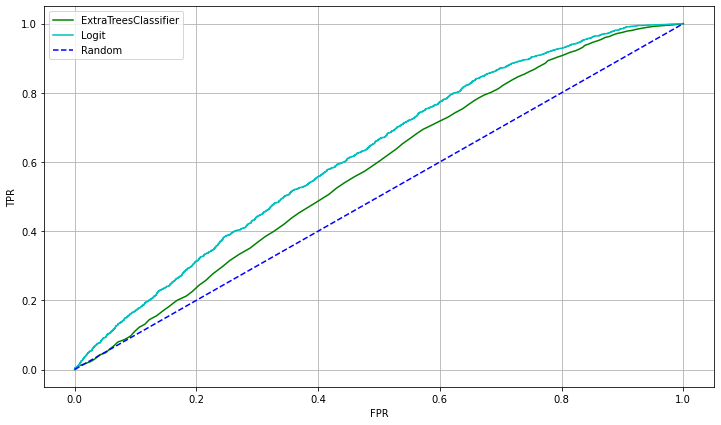

In [387]:
plt.figure(figsize=(12,7))
l = np.arange(0,1.1,.1)

plt.plot(fpr_tree,tpr_tree,'g-', label='ExtraTreesClassifier')
plt.plot(fpr_logit,tpr_logit,'c-', label='Logit')


plt.plot(l,l,'b--' , label='Random')
plt.legend(loc='best') 
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()

#### Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [405]:
from sklearn.metrics import mean_squared_error

In [417]:
tester = PCA(n_components=80,svd_solver='full' )
a = tester.fit_transform(X_scaled)
a_ = tester.inverse_transform(a)

mean_squared_error(X_scaled,a_)

0.00663845375403741

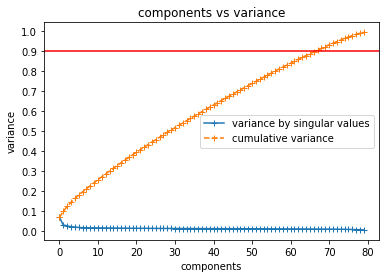

In [413]:
plt.plot(tester.explained_variance_ratio_,'+-', label = 'variance by singular values')
plt.plot(tester.explained_variance_ratio_.cumsum(),'+--',label = 'cumulative variance')
plt.axhline(.9,color='r')
plt.legend()
plt.yticks(np.arange(0,1.1,.1))
plt.xlabel('components')
plt.ylabel('variance')
plt.title('components vs variance');

In [422]:
tester.explained_variance_ratio_.cumsum()[67]

0.9039348288721171

Видно, что только на 67 компоненте снижение дисперсии составит 90%. 

In [412]:
# Посмтрим на собственные значения:
tester.singular_values_[:10]

array([403.53530862, 268.94131473, 244.65982561, 223.97318573,
       215.27287619, 202.59725741, 195.60298723, 193.13558613,
       191.98899522, 190.46222842])

Проверим на Mean Square Error (MSE) для 67 компонент:

In [423]:
tester = PCA(n_components=67,svd_solver='full' )
a = tester.fit_transform(X_scaled)
a_ = tester.inverse_transform(a)

mean_squared_error(X_scaled,a_)

0.10498728061390898

###  Вывод: 
- поскольку собственные значения матрицы X , очень большие, то снижение вариативности по каждой компоненте очень низкое.  
- нужно снижать до 67 компонент (из 84) чтобы не было потери информативности (до 90% дисперсии)